In [1]:
# 导入AI组件
import toad
import numpy as np
import pandas as pd
import joblib
from sklearn.metrics import roc_curve, auc

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.pyplot import MultipleLocator
from sklearn.metrics import confusion_matrix
from sklearn.tree import plot_tree

from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

from statsmodels.nonparametric.smoothers_lowess import lowess
from scipy.signal import find_peaks
from scipy.stats import skew, kurtosis
from numpy import correlate
import nolds

# 配置Matplotlib以使用中文字体
from matplotlib.font_manager import FontProperties
font = FontProperties(fname="C:/Windows/Fonts/simsun.ttc", size=12)
plt.rcParams['font.family'] = ['sans-serif']
plt.rcParams['font.sans-serif'] = [font.get_name()]

In [2]:
# 读取数据，重采样并提取标签
df_raw = pd.read_csv('data.csv', dtype=str)
raw_list = df_raw['raw'].apply(lambda x: eval(x)).to_list()
df = pd.DataFrame([
    np.interp(
        np.linspace(0, len(raw), 200), np.arange(len(raw)), raw
        ) / max(raw) for raw in raw_list
    ])
df.insert(0, 'label', df_raw['label'])

In [ ]:
# 平滑并归一化
X = df.drop(columns=['label'])
y = df['label']
X1 = pd.DataFrame(X.apply(
    lambda x: lowess(x, range(len(x)), frac=0.03)[:,1], axis=1
    ).to_list())
X1_normalized = X1.apply(lambda x: x/max(x), axis=1)
X2_normalized = X.apply(lambda x: x/max(X1.loc[x.name]), axis=1)

In [ ]:
# 提取特征
def get_features(x):

    peaks, _ = find_peaks(x*-1)
    num_peaks = len(peaks)
    peak_heights = x[peaks]

    spi = peaks[np.argsort(peak_heights)[::-1]]
    sph = np.sort(peak_heights)[::-1]
    peak0 = spi[0] if len(peaks)>0 else -1
    peak1 = spi[1] if len(peaks)>1 else -1
    peak2 = spi[2] if len(peaks)>2 else -1
    ph0 = sph[0] if len(peaks)>0 else -1
    ph1 = sph[1] if len(peaks)>1 else -1
    ph2 = sph[2] if len(peaks)>2 else -1
    
    average_slope = (x.iloc[-1] - x.iloc[0]) / len(x)
    waveform_length = (x[1:].reset_index(drop=True) - x[:-1].reset_index(drop=True)).sum()
    mid_point = min(x) + (max(x) - min(x))/2 
    num_zero_crossings = (
        ((x[:-1].reset_index(drop=True) - mid_point) * (x[1:].reset_index(drop=True) - mid_point)
         ) < 0).sum()
 
    curve_length = np.sum(np.abs(np.diff(x)))
    max_autocorrelation = np.max(correlate(x, x, mode='full')[len(x):])
    
    return [
        (x ** 2).sum(),
        num_peaks,
        x.sum(),
        num_zero_crossings,
        ph0,
        ph1,
        ph2,
        x.std(),
        x.min(),
        skew(x), 
        kurtosis(x),
        x.mean(),
        x.quantile(0.1),
        x.quantile(0.2),
        x.quantile(0.3),
        x.quantile(0.4),
        x.quantile(0.5),
        x.quantile(0.6),
        x.quantile(0.7),
        x.quantile(0.8),
        x.quantile(0.9),
        nolds.sampen(x),
        curve_length,
        max_autocorrelation
    ]
X_features = X1_normalized.apply(lambda x: get_features(x), axis=1)
X_features = pd.DataFrame(X_features.tolist(), columns=[
    'energy',
    'num_peaks',
    'area_under_curve',
    'num_zero_crossings',
    'ph0', 
    'ph1', 
    'ph2', 
    'std', 
    'min', 
    'skew', 
    'kurtosis',
    'mean',
    'x10',
    'x20',
    'x30',
    'x40',
    'x50',
    'x60',
    'x70',
    'x80',
    'x90',
    'entropy',
    'curve_length',
    'max_autocorrelation'
    ])

In [7]:
# 交叉验证寻找优化的模型参数
param_grid = {
    'n_estimators': [20, 125],
    'max_depth': [6, 13],
    'min_samples_split': [5, 9],
    'min_samples_leaf': [1],
    'max_features': ['auto']
}

rf = RandomForestClassifier()
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, 
                           cv=7, n_jobs=-1, verbose=2)
grid_search.fit(X_features, y)
print(grid_search.best_params_)

Fitting 7 folds for each of 8 candidates, totalling 56 fits
{'max_depth': 13, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 125}


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.


building tree 1 of 100
building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100

building tree 26 of 100
building tree 27 of 100building tree 28 of 100
building tree 29 of 100

building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100building tree 34 of 100

building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100bu

[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  69 out of 100 | elapsed:    2.4s remaining:    1.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.5s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs

Cross-Validation Scores: [0.91360413 0.91548387 0.92451613]
Average CV Score: 0.9178680421233613
 CV Score std: 0.004763133044491485


std: 0.1143
x10: 0.0974
curve_length: 0.0953
min: 0.0818
entropy: 0.0809
skew: 0.0704
x20: 0.0514
kurtosis: 0.0472
num_zero_crossings: 0.0416
area_under_curve: 0.0348
mean: 0.0322
x60: 0.0315
x30: 0.0308
num_peaks: 0.0298
x70: 0.0278
max_autocorrelation: 0.0242
x50: 0.0209
energy: 0.0170
x40: 0.0162
x80: 0.0134
ph1: 0.0110
ph0: 0.0110
ph2: 0.0102
x90: 0.0090


Text(0, 0.5, '特征名称')

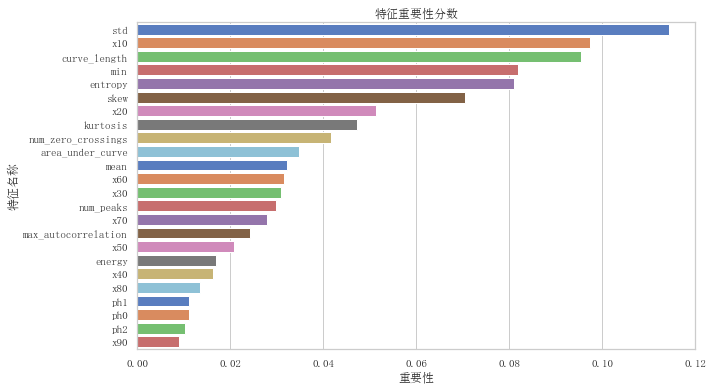

In [ ]:
# 交叉验证模型参数并统计特征重要性
clf = RandomForestClassifier(
    n_estimators=125, 
    max_depth=13, 
    min_samples_leaf=1, 
    min_samples_split=5, 
    n_jobs=-1, 
    verbose=3
    )
clf.fit(X_features, y)

cross_val_scores = cross_val_score(clf, X_features, y, cv=3, scoring="accuracy")
print(f"Cross-Validation Scores: {cross_val_scores}")
print(f"Average CV Score: {cross_val_scores.mean()}")
print(f" CV Score std: {cross_val_scores.std()}")

feature_importances = clf.feature_importances_
feature_names = X_features.columns

features_sorted = sorted(zip(feature_names, feature_importances), key=lambda x: x[1], reverse=True)

print('\n')
for name, importance in features_sorted:
    print(f"{name}: {importance:.4f}")

feature_importance = pd.DataFrame()
feature_importance['x'] = feature_importances
feature_importance['y'] = X_features.columns
feature_importance = feature_importance.sort_values('x', ascending=False)

sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.barplot(x="x", y="y", data=feature_importance, palette='muted')
plt.rcParams['font.family'] = ['sans-serif']
plt.rcParams['font.sans-serif'] = [font.get_name()]
plt.title('特征重要性分数')
plt.xlabel('重要性')
plt.ylabel('特征名称')

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.


building tree 1 of 125
building tree 2 of 125
building tree 3 of 125
building tree 4 of 125
building tree 5 of 125
building tree 6 of 125
building tree 7 of 125
building tree 8 of 125
building tree 9 of 125
building tree 10 of 125
building tree 11 of 125
building tree 12 of 125
building tree 13 of 125
building tree 14 of 125
building tree 15 of 125
building tree 16 of 125
building tree 17 of 125
building tree 18 of 125
building tree 19 of 125
building tree 20 of 125
building tree 21 of 125
building tree 22 of 125
building tree 23 of 125building tree 24 of 125

building tree 25 of 125
building tree 26 of 125building tree 27 of 125

building tree 28 of 125
building tree 29 of 125
building tree 30 of 125
building tree 31 of 125
building tree 32 of 125
building tree 33 of 125
building tree 34 of 125
building tree 35 of 125building tree 36 of 125

building tree 37 of 125
building tree 38 of 125
building tree 39 of 125
building tree 40 of 125
building tree 41 of 125building tree 42 of 125

b

[Parallel(n_jobs=-1)]: Done 125 out of 125 | elapsed:    0.4s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done 125 out of 125 | elapsed:    0.0s finished


              precision    recall  f1-score   support

          其它       0.88      0.86      0.87       276
          坑蚀       0.95      0.95      0.95       284
          开裂       0.87      0.89      0.88       273
          点蚀       0.96      0.96      0.96       296
          磨蚀       0.99      0.99      0.99       267

    accuracy                           0.93      1396
   macro avg       0.93      0.93      0.93      1396
weighted avg       0.93      0.93      0.93      1396



Text(65.515625, 0.5, '实际类型')

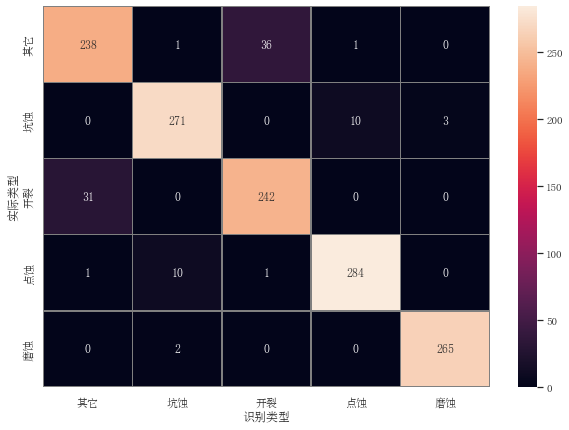

In [ ]:
# 评估模型性能
X_train, X_test, y_train, y_test = train_test_split(X_features, y, test_size=0.3)
clf = RandomForestClassifier(
    n_estimators=125, 
    max_depth=13, 
    min_samples_leaf=1, 
    min_samples_split=5, 
    n_jobs=-1, 
    verbose=3
    )
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
report = classification_report(y_test, y_pred)
rd = classification_report(y_test, y_pred, output_dict=True)
labels_order = list(rd.keys())[:-3]
print(report)

cm = confusion_matrix(y_test, y_pred, labels=labels_order)
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='g', xticklabels=labels_order, yticklabels=labels_order, linewidths=0.5, linecolor='gray')
plt.xlabel('识别类型')
plt.ylabel('实际类型')

In [ ]:
# 训练完整的模型并保存
clf = RandomForestClassifier(
    n_estimators=125, 
    max_depth=13, 
    min_samples_leaf=1, 
    min_samples_split=5, 
    n_jobs=-1, 
    verbose=3
    )
clf.fit(X_features, y)
joblib.dump(clf, 'test_model.pkl')

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.


building tree 1 of 125
building tree 2 of 125
building tree 3 of 125
building tree 4 of 125
building tree 5 of 125
building tree 6 of 125building tree 7 of 125

building tree 8 of 125
building tree 9 of 125
building tree 10 of 125
building tree 11 of 125
building tree 12 of 125
building tree 13 of 125
building tree 14 of 125
building tree 15 of 125
building tree 16 of 125
building tree 17 of 125
building tree 18 of 125
building tree 19 of 125
building tree 20 of 125
building tree 21 of 125
building tree 22 of 125
building tree 23 of 125
building tree 24 of 125
building tree 25 of 125
building tree 26 of 125
building tree 27 of 125building tree 28 of 125
building tree 29 of 125

building tree 30 of 125
building tree 31 of 125
building tree 32 of 125
building tree 33 of 125
building tree 34 of 125building tree 35 of 125
building tree 36 of 125
building tree 37 of 125

building tree 38 of 125
building tree 39 of 125
building tree 40 of 125
building tree 41 of 125
building tree 42 of 125
b

[Parallel(n_jobs=-1)]: Done 125 out of 125 | elapsed:    0.4s finished


['test_model.pkl']